In [7]:
import geopandas as gpd
import numpy as np
import time 
from shapely.geometry import Point
import matplotlib.pyplot as plt

**Testing visualization comparisons for complex and simple polygons**

In [36]:
# Generate 500 complex polygons
def create_complex_poly(center_pt, vertices=500):
    return center_pt.buffer(1, resolution=vertices)

In [37]:
# Create dummy points across a coordinate space
points = [Point(x,y) for x,y in zip(np.random.uniform(0,10,500), np.random.uniform(0,10,500))]
gdf = gpd.GeoDataFrame({'id':range(500), 'geometry':[create_complex_poly(p) for p in points]}, crs="EPSG:4326")

In [38]:
# Benchmarking function
def benchmark_geos(df, label, n_obs=100, simplify_tol=None):
    start = time.time()
    test_df = df.copy()
    if simplify_tol:
         # The Douglas-Peucker algorithm
        test_df['geometry'] = test_df.simplify(tolerance=simplify_tol, preserve_topology=True)
    
    # Simulate handoff to browser (conversion to GeoJSON string)
    geojson_str = test_df.to_json()
    duration = time.time() - start
    size_kb = len(geojson_str) / 1024
    total_v = test_df.geometry.apply(lambda g: len(g.exterior.coords) if g else 0).sum()

    # Visualization
    fig, ax = plt.subplots(figsize=(6,4))
    test_df.head(n_obs).plot(ax=ax, color='skyblue', edgecolor='black', alpha=0.6)

    ax.set_title(f"{label}\nSize: {size_kb:.1f}KB | Vertices: {total_v:,}")
    ax.axis('off')
    plt.show()

    print(f"--- {label} ---")
    print(f"Processing Time: {duration:.4f} seconds")
    print(f"GeoJSON Size:    {size_kb:.2f} KB")
    print(f"Total Vertices:  {total_v:,}")

    plt.close()
    
    return duration, size_kb

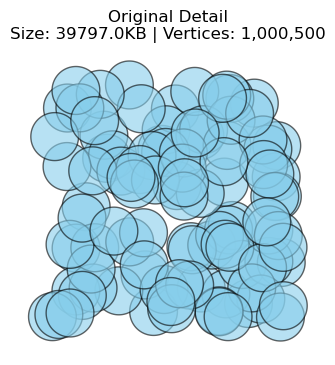

--- Original Detail ---
Processing Time: 1.5208 seconds
GeoJSON Size:    39797.00 KB
Total Vertices:  1,000,500




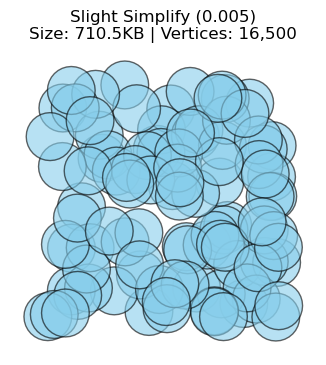

--- Slight Simplify (0.005) ---
Processing Time: 1.0553 seconds
GeoJSON Size:    710.49 KB
Total Vertices:  16,500




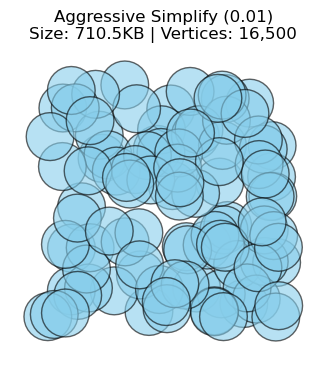

--- Aggressive Simplify (0.01) ---
Processing Time: 0.9640 seconds
GeoJSON Size:    710.49 KB
Total Vertices:  16,500




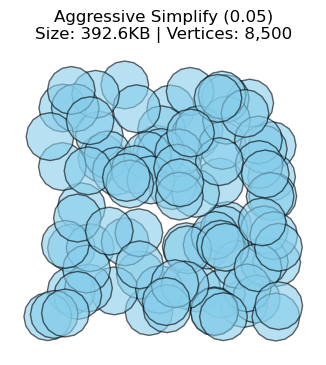

--- Aggressive Simplify (0.05) ---
Processing Time: 0.8307 seconds
GeoJSON Size:    392.59 KB
Total Vertices:  8,500




In [41]:
# 1. Baseline
benchmark_geos(gdf, "Original Detail")
print("\n")

# 2. Slight Simplification (The Sweet Spot)
benchmark_geos(gdf, "Slight Simplify (0.005)", simplify_tol=0.005)
print("\n")

# 3. In-Between Simplification
benchmark_geos(gdf, "Aggressive Simplify (0.01)", simplify_tol=0.01)
print("\n")

# 3. Aggressive Simplification
benchmark_geos(gdf, "Aggressive Simplify (0.05)", simplify_tol=0.05)
print("\n")